# Average number of business visitors in New Zealand



This dataset provides the average number of visitors in New Zealand for the porpose of business from 1998 - 2010.

The problem is to forecast the average number of business visitors in New Zealand.

Learn more about the dataset and download it from [here](http://new.censusatschool.org.nz/resource/time-series-data-sets-2012/).

I will use python to analyse and forecast this time series data.

## 1. Loading and Handling Time Series in Pandas

Let's start by importing the required libraries:

In [3]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from scipy.stats import boxcox
from math import sqrt
from math import log
from math import exp
import warnings

os.chdir("D:/Python/NZVistors Time Series")

Now, we can load the dataset and look at some initial rows and data types of the columns:

In [4]:
df_data = pd.read_csv("data/Average-number-of-visitors-in-New-Zealand-for-business.csv", header=0)

# format time attribute
dates = pd.to_datetime(df_data["Date"], format = '%YM%m')
df_data["Date"] = dates.apply(lambda x: x.strftime('%Y-%m-%d'))

df_data.to_csv("processed/dataset.csv", index=False)

series = pd.Series.from_csv("processed/dataset.csv", header=0)

print(series.head())

print('\n Data Types:')
print(series.dtypes)

Date
1998-09-01    6387
1998-10-01    6798
1998-11-01    7068
1998-12-01    5682
1999-01-01    5454
Name: Business, dtype: int64

 Data Types:
int64


The code below will first split the original dataset into two, one for model development (dataset.csv) and the other for test the final model(test.csv). This final year of data will be used to test the final model.


In [5]:
# create dataset.csv and test.csv
split_point = len(series) - 5
dataset, test = series[0:split_point], series[split_point:]
print('Dataset %d, Test %d' % (len(dataset), len(test)))
dataset.to_csv('processed/dataset.csv')
test.to_csv('processed/test.csv')

Dataset 160, Test 5


The below summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [6]:
print(dataset.describe())

count      160.000000
mean      7645.325000
std       1081.526673
min       5454.000000
25%       6906.250000
50%       7603.500000
75%       8300.250000
max      10506.000000
Name: Business, dtype: float64


## 2. Visualizing Time Series Data


### Line plot

The data was plotted as a time series with the yesr along the x-axis and number figures on the y-axis.

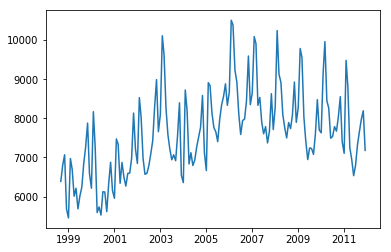

In [7]:
plt.plot(dataset)
plt.show()

It is clearly evident that there is a clear trend in the data along with some seasonal variations. 

This may suggest that the time series is not stationary and will require differencing to make it stationary. 

### Autocorrelation plot
Let's take a quick look at an autocorrelation plot of the time series.

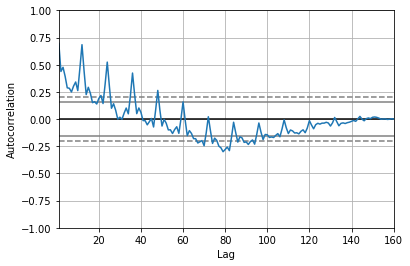

In [8]:
autocorrelation_plot(dataset)
plt.show()

The resulting plot shows lag along the x-axis and the correlation on the y-axis. Dotted lines are provided that indicate any correlation values above those lines are statistically significant.

We can see strong positive correlation with the first few lags and the wave cycles seen in the above plot are a strong sign of seasonality in the dataset.

Also, the time series does not shows a strong temporal dependence that decays linearly or in a similar pattern, which indicates that this time series is not a Random Walk.

### Density plot

Another important visualization is of the distribution of observations themselves. This plot can provide a clearer summary of the distribution.

The plot below shows a distribution that looks strongly Gaussian. 

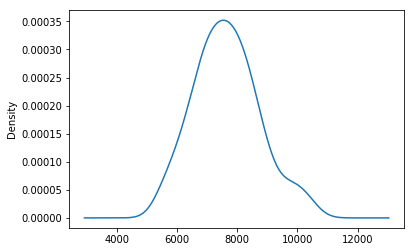

In [9]:
dataset.plot(kind='kde')
plt.show()

### Box and Whisker Plots

We can group the monthly data by year and get an idea of the spread of observations for each year and how this may be changing.

The first year (1998) only contains 4 months and may not be a useful comparison with the other 12 months of observations in the other years. Therefore only data between 1998 and 2011 was plotted.

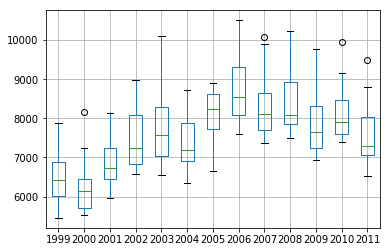

In [10]:
groups = dataset['1999':'2011'].groupby(pd.TimeGrouper('A'))
years = pd.DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
plt.show()

The observations suggest that the median values for each year show a trend that may not be linear, and the spread values are differ and not consistently over time.

### Decomposition plot 

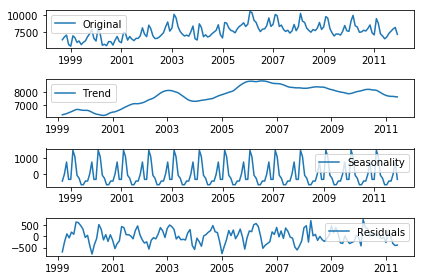

In [11]:
decomposition = seasonal_decompose(dataset)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dataset, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Here we can see an overview of the data with different compositions.

## 3. Baseline model

Before building the model, we will convert the dataset to float32 in case the loaded data still has some String or Integer data types and split the dataset into train and validation sets.

In [12]:
# prepare data
# split into train and validation sets
X = dataset.values.astype('float32')
train_size = int(len(X) * 0.60)
train, validation = X[0:train_size], X[train_size:]

A baseline in forecast performance can provide a point of comparison. If a model achieves performance at or below the baseline, the technique should be fixed or abandoned.

Baseline model:
Test RMSE: 829.924


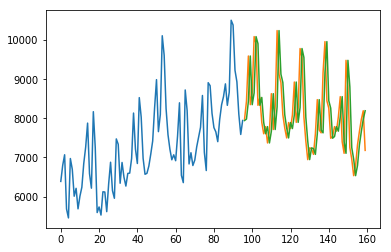

In [13]:
# Baseline model
def baseline_model(train, test):
        # walk-forward validation
        history = [x for x in train]
        predictions = list()
        for i in range(len(test)):
            # predict
            yhat = history[-1]
            predictions.append(yhat)
            
            # observation
            obs = validation[i]
            history.append(obs)
        mse = mean_squared_error(test, predictions)
        rmse = sqrt(mse)
        print('Baseline model:')
        print('Test RMSE: %.3f' % rmse)

        # plot predictions and expected results
        plt.plot(train)
        plt.plot([None for i in train] + [x for x in test])
        plt.plot([None for i in train] + [x for x in predictions])
        plt.show()
        
        return predictions


predictions = baseline_model(train, validation)


From the plot of the persistence model predictions, it is clear that the model is 1-step behind reality. 

## 4. Forecasting a Time Series - ARIMA Model

### 4.1 Manually Configured ARIMA

First, we should check stationarity by using rolling statistics plots and Dickey-Fuller Test

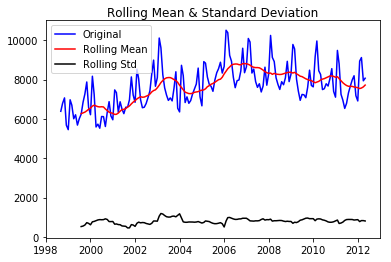

Results of Dickey-Fuller Test:
Test Statistic                  -1.733632
p-value                          0.413873
#Lags Used                      14.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64


In [14]:
# check if it is stationary
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


test_stationarity(series)

Though the variation in standard deviation is small, mean is clearly varying with time. This time series is not a stationary series.

In termd of Dickey-Fuller test, the null hypothesis of the test is that the time series is not stationary. The alternate hypothesisis is that the time series is stationary.

The test statistic of -1.7 is more than the value of -2.57 at 10%, mesning that we can accept the null hypothesis that the time series is non-stationary and does have time-dependent structure.


Next, I will use differencing to make this time series towards stationarity.

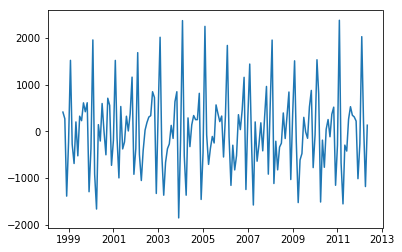

In [15]:
ts_diff = series - series.shift()

plt.plot(ts_diff)
plt.show()

Let's check the stationality again.

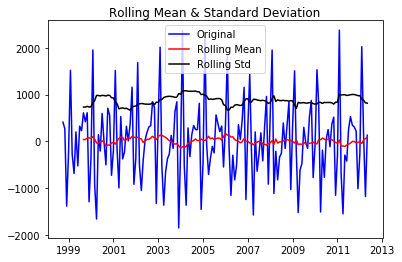

Results of Dickey-Fuller Test:
Test Statistic                  -3.818756
p-value                          0.002721
#Lags Used                      13.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64


In [16]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 1% critical value, thus the time series is stationary with 99% confidence. 

This suggests that one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1.


The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

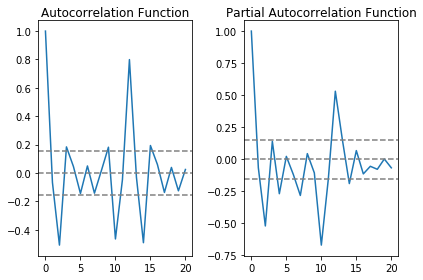

In [17]:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values. We can see that the values of p and q are both about 2 or 3.

### 4.2 Using a grid search of ARIMA to find an optimized model.

We can automate the process of training and evaluating ARIMA models on different combinations of model hyperparameters using Grid Search, and then print the RMSE for each. I will also use walk-forward validation, which provids a much more robust estimation of how the chosen modeling method and parameters will perform.

In [18]:
# Grid Search ARIMA Hyperparameters
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
	# walk-forward validation
	history = [x for x in train]
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)

		obs = test[t]
		history.append(obs)
		#print('predicted=%f, expected=%f' % (yhat, obs))
		
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
	best_score, best_cfg = float("inf"), None

	# Iterate ARIMA Parameters
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(train, test, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 4)
d_values = range(1, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(train, validation, p_values, d_values, q_values)

ARIMA(0, 1, 0) RMSE=833.478
ARIMA(0, 1, 1) RMSE=838.640
ARIMA(0, 1, 2) RMSE=766.522
ARIMA(0, 1, 3) RMSE=771.683
ARIMA(0, 2, 0) RMSE=1209.685
ARIMA(0, 2, 1) RMSE=842.636
ARIMA(1, 1, 0) RMSE=833.929
ARIMA(1, 1, 1) RMSE=798.928
ARIMA(1, 1, 2) RMSE=761.669
ARIMA(1, 1, 3) RMSE=788.559
ARIMA(1, 2, 0) RMSE=1147.612
ARIMA(1, 2, 1) RMSE=843.378
ARIMA(2, 1, 0) RMSE=768.560
ARIMA(2, 1, 1) RMSE=780.515
ARIMA(2, 1, 2) RMSE=790.861
ARIMA(2, 2, 0) RMSE=925.180
ARIMA(2, 2, 1) RMSE=777.403
ARIMA(2, 2, 2) RMSE=789.980
ARIMA(3, 1, 0) RMSE=768.525
ARIMA(3, 1, 1) RMSE=789.059
ARIMA(3, 1, 2) RMSE=762.424
ARIMA(3, 2, 0) RMSE=916.592
ARIMA(3, 2, 1) RMSE=777.643
ARIMA(3, 2, 2) RMSE=798.316
Best ARIMA(1, 1, 2) RMSE=761.669


The best parameters of ARIMA(1, 1, 2) are reported at the end of the run with a RMSE of 761.669.

Next, I will use the best parameters to make a ARIMA model.

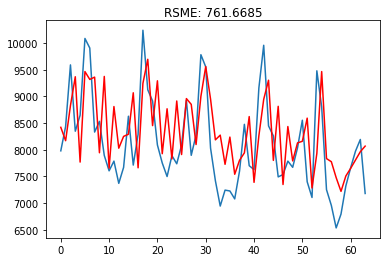

In [19]:
# ARIMA model
# an ARIMA model for a given order (p,d,q)
def arima_model(train, test,  arima_order):
    # walk forward over time steps in test
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		output = model_fit.forecast()
		yhat = output[0][0]
		predictions.append(yhat)
		obs = test[t]
		history.append(obs)
		#print('predicted=%f, expected=%f' % (yhat, obs))
		
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
    
	# plot
	plt.plot(test)
	plt.plot(predictions, color='red')
	plt.title('RSME: %.4f'% rmse)
	plt.show()

	return predictions

warnings.filterwarnings("ignore")
predictions = arima_model(train, validation, (1, 1, 2))


A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). 
We can see the values show some trend and are in the correct scale.

### 4.3 Analysis of forecast residual errors to evaluate any bias in the model.

A good final check of a model is to review residual forecast errors.

In [20]:
# calculate residuals
residuals = [validation[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

#### Residual Line Plot

The first plot is to look at the residual forecast errors over time as a line plot.

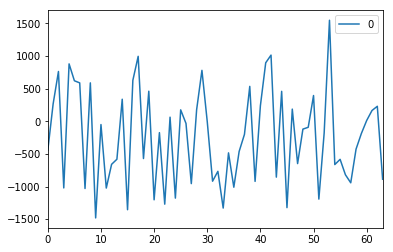

In [21]:
# plot residuals
residuals.plot()
plt.show()

#### Residual Summary Statistics

We can see how the errors are spread around zero from summary statistics. This includes the mean and standard deviation of the distribution, as well as percentiles and the minimum and maximum errors observed.

It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior to their use or evaluation.

In [22]:
# summary statistics
print(residuals.describe())

                 0
count    64.000000
mean   -235.109187
std     730.201183
min   -1481.431140
25%    -895.937581
50%    -182.842631
75%     284.695735
max    1548.992990


The summary above shows a mean error value does not close to zero. It suggests that there may be some bias in the model. 

#### Residual Density Plots

Density Plots can be used to better understand the distribution of errors beyond summary statistics and discover skews in this distribution.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

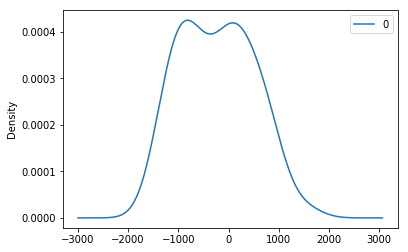

In [23]:
# density plot
residuals.plot(kind='kde')
plt.show()

There are some bias in the model and we may be able to further improve the model by performing a bias correction. This could be done by adding the mean residual error to forecasts or performing a transform to the data prior to modeling, such as taking the log or square root.

### 4.4 Explore improvements to the model using power transforms

The Box-Cox transform is a method that is able to evaluate a suite of power transforms, including, but not limited to, log, square root, and reciprocal transforms of the data.

The process involves first performimg a log transform of the history prior to fitting the ARIMA model, then inverting the transform on the prediction before storing it for later comparison with the expected values.

By convention, lambda values are evaluated between -5 and 5. However, the boxcox() function can fail. it appears to be signaled by a returned lambda value of less than -5. 

A check is added for a lambda value less than -5, and if this the case, a lambda value of 1 is assumed and the raw history is used to fit the model. A lambda value of 1 is the same as “no-transform” and therefore the inverse transform has no effect.

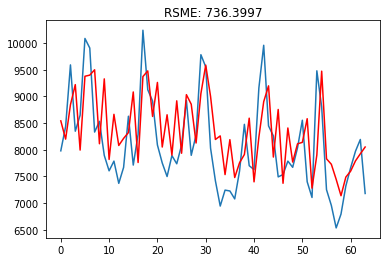

In [24]:
# Transform ARIMA model
# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# an transform ARIMA model for a given order (p,d,q)
def transform_arima_model(train, test, arima_order):
	# walk-forward validation
	history = [x for x in train]
	predictions = list()
	for t in range(len(test)):
		# transform
		transformed, lam = boxcox(history)
		if lam < -5:
		    transformed, lam = history, 1
					
		model = ARIMA(transformed, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]

		# invert transformed prediction
		yhat = boxcox_inverse(yhat, lam)
		
		predictions.append(yhat)

		obs = test[t]
		history.append(obs)

		#print('predicted=%f, expected=%f' % (yhat, obs))
		
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
    
	# plot
	plt.plot(test)
	plt.plot(predictions, color='red')
	plt.title('RSME: %.4f'% rmse)
	plt.show()

	return predictions

warnings.filterwarnings("ignore")
predictions = transform_arima_model(train, validation, (1, 1, 2))

The final RMSE of the model on the transformed data was 736.3997. This is a smaller error than the ARIMA model on untransformed data, but only slightly, and it may or may not be statistically different.


It is usually necessary to investigate the residual forecast errors on the model with Box-Cox transforms to see if there is a further bias.

                 0
count    64.000000
mean   -236.431047
std     702.926246
min   -1435.791013
25%    -872.296127
50%    -194.676426
75%     273.801589
max    1578.491704


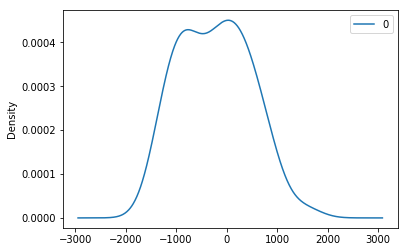

In [25]:
# calculate residuals
residuals = [validation[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

# summary statistics
print(residuals.describe())

# density plot
residuals.plot(kind='kde')
plt.show()

The summary and desity plot above shows the residual forecast errors on the model with Box-Cox transforms and without transforms are almost the same.

We will use this model with the Box-Cox transform as the final model.

## 5. Model Validation

After models have been developed and a final model selected, it must be finalized and  validated.

### Finalize Model

Finalizing the model involves fitting an ARIMA model on on a transformed version of the entire dataset.

Once fit, the model can be saved to file for later use. Because a Box-Cox transform is also performed on the data, we need to know the chosen lambda so that any predictions from the model can be converted back to the original, untransformed scale.

In [26]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
 
ARIMA.__getnewargs__ = __getnewargs__

# load data
dataset = pd.Series.from_csv('processed/dataset.csv')
# prepare data
X = dataset.values.astype('float32')
# transform data
warnings.filterwarnings("ignore")
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(1, 1, 2))
model_fit = model.fit(disp=0)
# save model
model_fit.save('output/model.pkl')
np.save('output/model_lambda.npy', [lam])

### Validate Model

In the first section, we saved the final 5 months of the original dataset in a separate file to validate the final model.

Now, the test.csv file can be loaded and used see how well our model really is on unseen data.

We will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the observations as an update to the history.

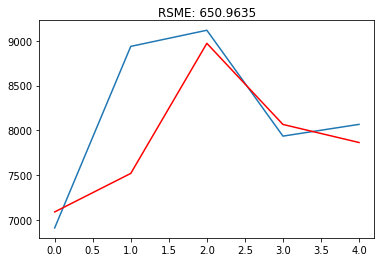

In [28]:
# Transform ARIMA model
# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# load and prepare datasets
dataset = pd.Series.from_csv('processed/dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
test = pd.Series.from_csv('processed/test.csv')
Y = test.values.astype('float32')

# load model
model_fit = ARIMAResults.load('output/model.pkl')
lam = np.load('output/model_lambda.npy')

warnings.filterwarnings("ignore")

# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(Y[0])
#print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(Y)):
	# transform
	transformed, lam = boxcox(history)
	if lam < -5:
		transformed, lam = history, 1

	# predict
	model = ARIMA(transformed, order=(1, 1, 2))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]

	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)

	predictions.append(yhat)
	# observation
	obs = Y[i]
	history.append(obs)
	#print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(Y, predictions)
rmse = sqrt(mse)

plt.plot(Y)
plt.plot(predictions, color='red')
plt.title('RSME: %.4f'% rmse)
plt.show()

## 6. Conclusion

We may be able to further improve the model by using a statistical test to check if the difference in results between different models is statistically significant, displaying the confidence intervals for the predictions on the test dataset, or considering data Selection.